In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import ast
import folium
from folium import plugins
import polyline
import os
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np
#from plotly.offline import plotly as py
#from plotly.offline import graph_objs as go
#import plotly.plotly as py
#import plotly.graph_objs as go
#init_notebook_mode(connected=True)
from src.data import make_dataset
from src.visualization import visualize
from dotenv import find_dotenv, load_dotenv
import os


%matplotlib inline
width = 10
height = 10
matplotlib.rcParams['figure.figsize'] = [width, height]
matplotlib.rcParams.update({'font.size': 14})

# import matplotlib.style
# import matplotlib as mpl
# mpl.style.use('default')

(strava_data, drives) = make_dataset.load_data()

# Access data store
#strava_data_h5 = pd.read_hdf(os.path.join('..', 'data', 'processed', 'strava_data.h5'))
#strava_data_h5 = pd.HDFStore(os.path.join('..', 'data', 'processed', 'strava_data.h5'))


# Retrieve data using key
#strava_data = strava_data_h5['strava_data']
#drive_morning = strava_data_h5['drive_morning']
#drive_evening = strava_data_h5['drive_evening']
#strava_data_h5.close()

In [2]:
def get_start_latlng(mp):
    pl = mp['summary_polyline']
    if pl:
        return(polyline.decode(pl)[0])
    
def get_end_latlng(mp):
    pl = mp['summary_polyline']
    if pl:
        return(polyline.decode(pl)[-1])

In [3]:
strava_data['start_latlng'] = strava_data['map'].apply(get_start_latlng)
strava_data['end_latlng'] = strava_data['map'].apply(get_end_latlng)
strava_data[['start_lat', 'start_lng']] = strava_data['start_latlng'].apply(pd.Series)
strava_data[['end_lat', 'end_lng']] = strava_data['end_latlng'].apply(pd.Series)

In [4]:
33.776260, -84.386822

(33.77626, -84.386822)

In [5]:
morning_mask = strava_data['start_date_local'].dt.hour.isin(range(7, 11))
evening_mask = strava_data['start_date_local'].dt.hour.isin(range(14, 20))
weekday_mask = strava_data['start_date_local'].dt.weekday.isin(range(0, 5))
normal_time_mask = ((strava_data['moving_time'].dt.seconds / 60) > 10) & ((strava_data['moving_time'].dt.seconds / 60) < 30)
bike_mask = strava_data['type'] == 'Ride'
distance_mask = (strava_data['distance'] > 2.3) & (strava_data['distance'] < 7)
work_start_mask = strava_data['start_lat'] >= 33.776
work_end_mask = strava_data['end_lat'] >= 33.776
year_mask = strava_data["start_date_local"].dt.year == 2019

In [6]:
drive_year_mask = drives["start_date_local"].dt.year == 2019
drive_time_mask = drives["elapsed_time"] > pd.Timedelta(minutes=3)
drive_morning = drives[(drives["start_date_local"].dt.hour.isin(range(7, 11))) & (drive_time_mask) & drive_year_mask]
drive_evening = drives[(drives["start_date_local"].dt.hour.isin(range(14, 20))) & (drive_time_mask) & drive_year_mask]

In [7]:
def add_from_locations(df):
    df['from'] = ''
    df['from'] = df['from'].mask(evening_mask & weekday_mask & normal_time_mask & distance_mask & work_start_mask, 'work')
    return df

def add_to_locations(df):
    df['to'] = ''
    df['to'] = df['to'].mask(morning_mask & weekday_mask & normal_time_mask & distance_mask & work_end_mask, 'work')
    return df

In [8]:
def heartrate_conversion(df):
    mask = ~pd.isnull(df['heartrate'])
    df.loc[mask, 'heartrate'] = (df[mask]['heartrate']).apply(ast.literal_eval)
    return df

In [9]:
#strava_data = heartrate_conversion(strava_data)

In [10]:
morning_commutes = strava_data[morning_mask & weekday_mask & normal_time_mask & distance_mask & work_end_mask & year_mask]
evening_commutes = strava_data[evening_mask & weekday_mask & normal_time_mask & distance_mask & work_start_mask & year_mask]

In [11]:
# Add columns to strava_data for the from and to strings for commutes
# This is duplication of information, but it makes it way easier for me to explore so it doesn't seem that horrible
strava_data = add_from_locations(strava_data)
strava_data = add_to_locations(strava_data)

/home/greg/.virtualenvs/commute_analysis/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


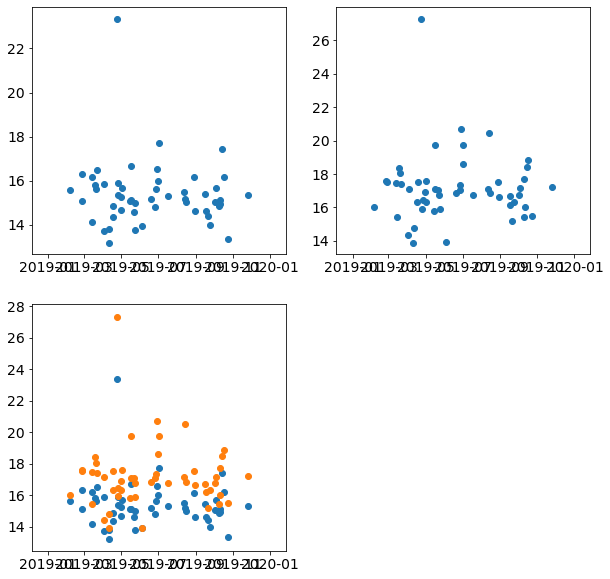

In [12]:
to_plot = visualize.prepare_for_plotting(morning_commutes)
plt.subplot(221)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'])
plt.subplot(222)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'])
plt.subplot(223)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'], color='C0')
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C1')


plt.show()

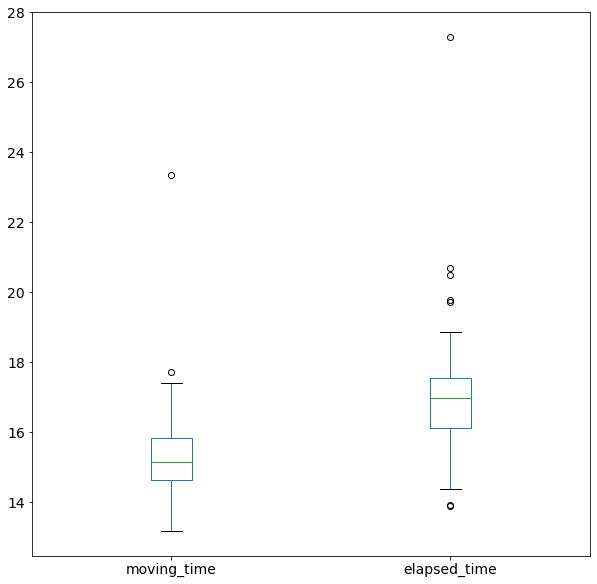

In [13]:
to_plot = visualize.prepare_for_plotting(morning_commutes)
to_plot[['moving_time', 'elapsed_time']].plot.box()
plt.show()


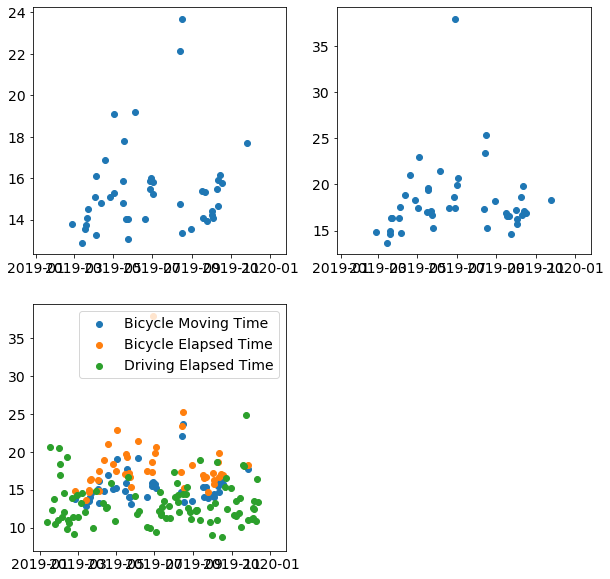

In [147]:
to_plot = visualize.prepare_for_plotting(evening_commutes)
to_plot_car = visualize.prepare_for_plotting(drive_evening.dropna())
plt.subplot(221)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'])
plt.subplot(222)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'])
plt.subplot(223)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'], color='C0')
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C1')
plt.scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C2')
plt.legend(['Bicycle Moving Time', 'Bicycle Elapsed Time', 'Driving Elapsed Time'])

plt.show()

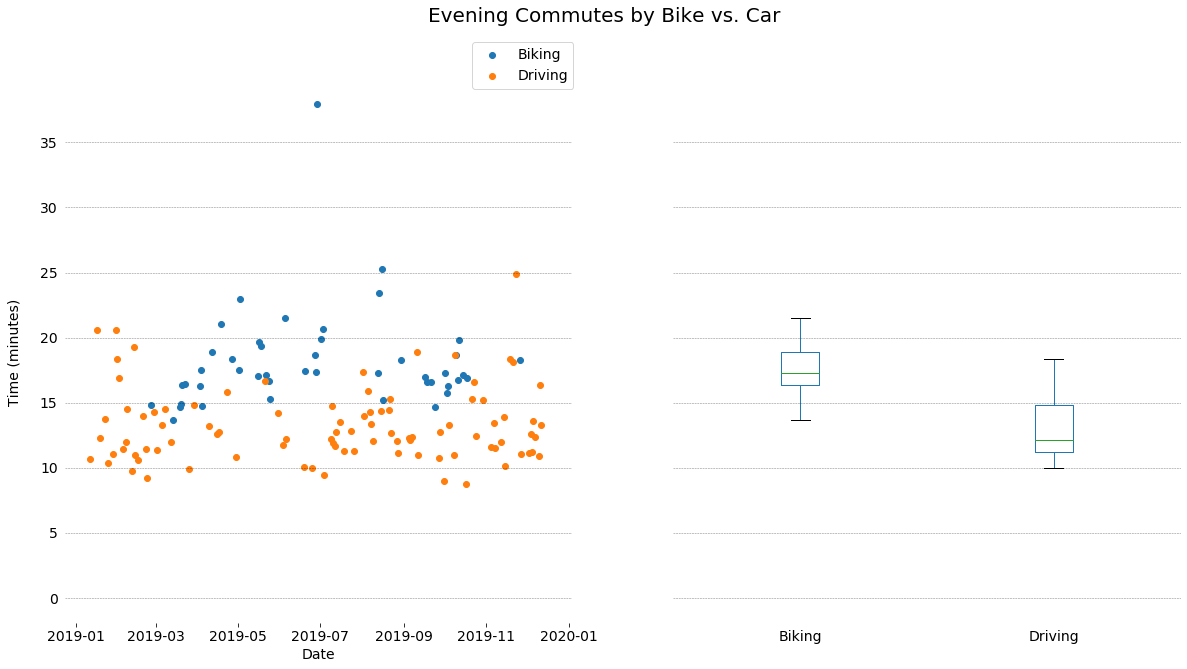

In [148]:
# Creating a nice plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
to_plot = visualize.prepare_for_plotting(evening_commutes)
to_plot_car = visualize.prepare_for_plotting(drive_evening.dropna())
axes[0].scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C0')
axes[0].scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C1')
axes[0].legend(['Biking', 'Driving'], bbox_to_anchor=[.79,.97])
to_plot_bike = to_plot
# BAD BAD BAD Below, lose a lot of data for the boxplot because of indexing garbage
to_plot['bike_moving_time'] = to_plot_bike['moving_time']
to_plot['Biking'] = to_plot_bike['elapsed_time']
to_plot['Driving'] = to_plot_car['elapsed_time']
to_plot[['Biking', 'Driving']].plot.box(ax=axes[1], showfliers=False)
fig.text(0.09, 0.5, 'Time (minutes)', ha='center', va='center', rotation='vertical')
axes[0].set_xlabel('Date')
fig.suptitle('Evening Commutes by Bike vs. Car', fontsize = 20)
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
#plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)
#plt.xticks(fontsize=14)
for y in range(0, 36, 5):
    for ax in axes:
        ax.tick_params(axis="both", which="both", bottom=False, top=False,
        labelbottom=True, left=False, right=False, labelleft=True)
        ax.axhline(y=y, linestyle='--', lw=0.5, color='black', alpha=0.5)
        #ax.plot_date([to_plot_car['start_date_local'].min(), to_plot_bike['start_date_local'].max()], [y, y],  "--", lw=0.5, color="black", alpha=0.9)
axes[0].tick_params(axis='both', which="both", bottom=True)
axes[1].tick_params(axis='both', labelleft=False)
# plt.savefig("figures/to_post.png", bbox_inches="tight")
plt.show()


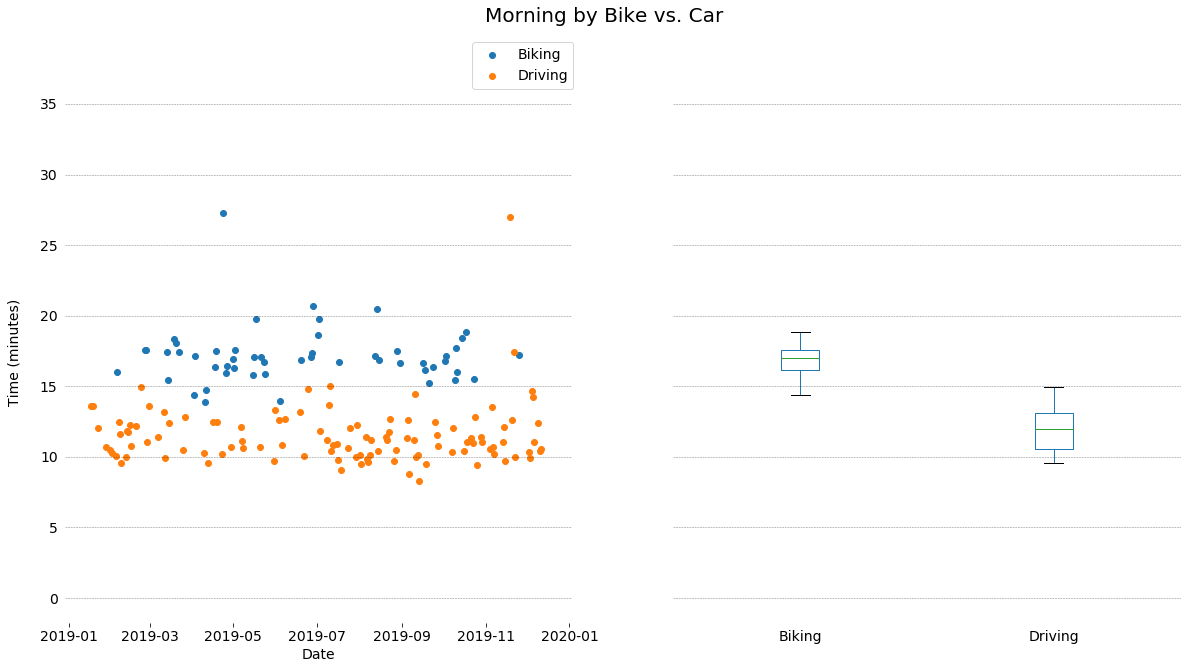

In [149]:
# Creating a nice plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
to_plot = visualize.prepare_for_plotting(morning_commutes)
to_plot_car = visualize.prepare_for_plotting(drive_morning.dropna())
axes[0].scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C0')
axes[0].scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C1')
axes[0].legend(['Biking', 'Driving'], bbox_to_anchor=[.79,.97])
# BAD BAD BAD Below, lose a lot of data for the boxplot because of indexing garbage
to_plot_bike = to_plot
to_plot['bike_moving_time'] = to_plot_bike['moving_time']
to_plot['Biking'] = to_plot_bike['elapsed_time']
to_plot['Driving'] = to_plot_car['elapsed_time']
to_plot[['Biking', 'Driving']].plot.box(ax=axes[1], showfliers=False)
fig.text(0.09, 0.5, 'Time (minutes)', ha='center', va='center', rotation='vertical')
axes[0].set_xlabel('Date')
fig.suptitle('Morning by Bike vs. Car', fontsize = 20)
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
#plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)
#plt.xticks(fontsize=14)
for y in range(0, 36, 5):
    for ax in axes:
        ax.tick_params(axis="both", which="both", bottom=False, top=False,
        labelbottom=True, left=False, right=False, labelleft=True)
        ax.axhline(y=y, linestyle='--', lw=0.5, color='black', alpha=0.5)
        #ax.plot_date([to_plot_car['start_date_local'].min(), to_plot_bike['start_date_local'].max()], [y, y],  "--", lw=0.5, color="black", alpha=0.9)
axes[0].tick_params(axis='both', which="both", bottom=True)
axes[1].tick_params(axis='both', labelleft=False)
# plt.savefig("figures/to_post.png", bbox_inches="tight")
plt.show()


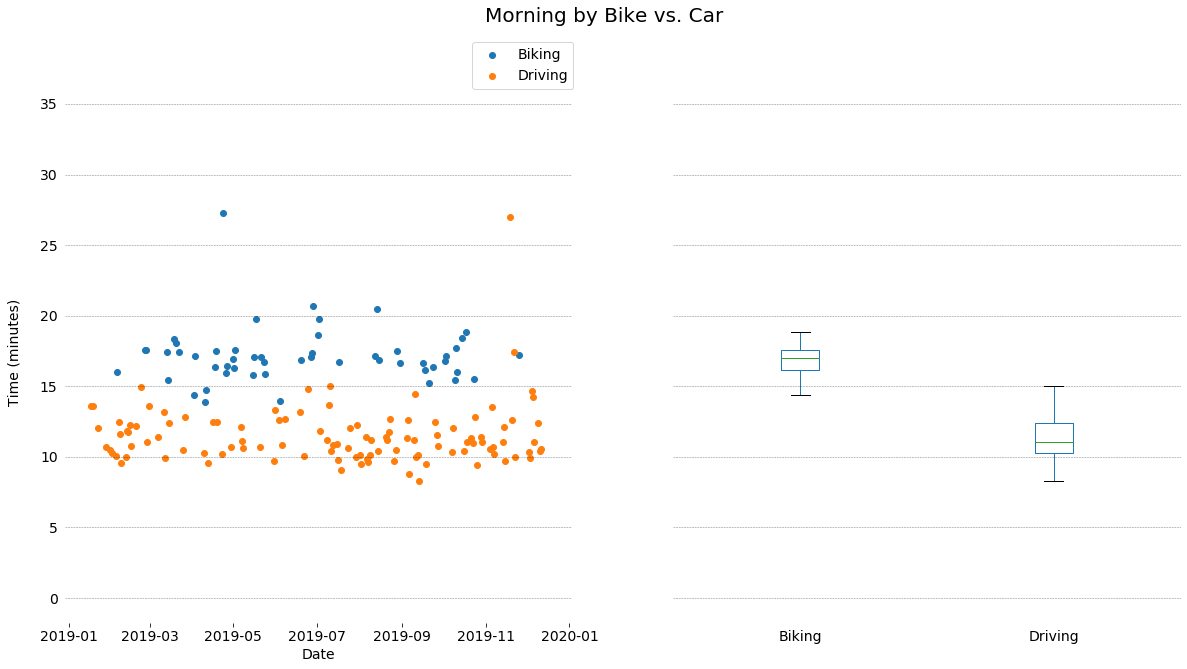

In [51]:
# Creating a nice plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
to_plot = visualize.prepare_for_plotting(morning_commutes)
to_plot_car = visualize.prepare_for_plotting(drive_morning.dropna())
axes[0].scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C0')
axes[0].scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C1')
axes[0].legend(['Biking', 'Driving'], bbox_to_anchor=[.79,.97])

hist_plot = pd.concat(
    (
        to_plot["elapsed_time"],
        to_plot_car["elapsed_time"],
    ),
    axis=1
)
hist_plot.columns = ["Biking", "Driving"]
hist_plot.plot.box(ax=axes[1], showfliers=False)


fig.text(0.09, 0.5, 'Time (minutes)', ha='center', va='center', rotation='vertical')
axes[0].set_xlabel('Date')
fig.suptitle('Morning by Bike vs. Car', fontsize = 20)
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
#plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)
#plt.xticks(fontsize=14)
for y in range(0, 36, 5):
    for ax in axes:
        ax.tick_params(axis="both", which="both", bottom=False, top=False,
        labelbottom=True, left=False, right=False, labelleft=True)
        ax.axhline(y=y, linestyle='--', lw=0.5, color='black', alpha=0.5)
        #ax.plot_date([to_plot_car['start_date_local'].min(), to_plot_bike['start_date_local'].max()], [y, y],  "--", lw=0.5, color="black", alpha=0.9)
axes[0].tick_params(axis='both', which="both", bottom=True)
axes[1].tick_params(axis='both', labelleft=False)
# plt.savefig("figures/to_post.png", bbox_inches="tight")
plt.show()




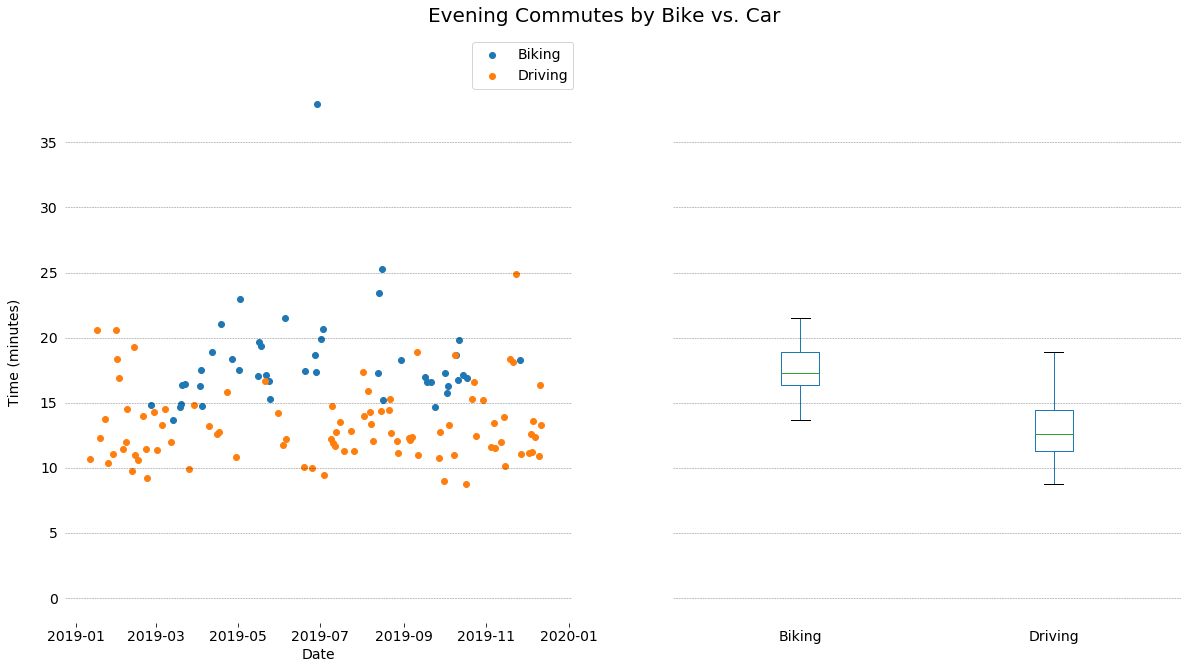

In [52]:
# Creating a nice plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
to_plot = visualize.prepare_for_plotting(evening_commutes)
to_plot_car = visualize.prepare_for_plotting(drive_evening.dropna())
axes[0].scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C0')
axes[0].scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C1')
axes[0].legend(['Biking', 'Driving'], bbox_to_anchor=[.79,.97])
hist_plot = pd.concat(
    (
        to_plot["elapsed_time"],
        to_plot_car["elapsed_time"],
    ),
    axis=1
)
hist_plot.columns = ["Biking", "Driving"]
hist_plot.plot.box(ax=axes[1], showfliers=False)
fig.text(0.09, 0.5, 'Time (minutes)', ha='center', va='center', rotation='vertical')
axes[0].set_xlabel('Date')
fig.suptitle('Evening Commutes by Bike vs. Car', fontsize = 20)
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
#plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)
#plt.xticks(fontsize=14)
for y in range(0, 36, 5):
    for ax in axes:
        ax.tick_params(axis="both", which="both", bottom=False, top=False,
        labelbottom=True, left=False, right=False, labelleft=True)
        ax.axhline(y=y, linestyle='--', lw=0.5, color='black', alpha=0.5)
        #ax.plot_date([to_plot_car['start_date_local'].min(), to_plot_bike['start_date_local'].max()], [y, y],  "--", lw=0.5, color="black", alpha=0.9)
axes[0].tick_params(axis='both', which="both", bottom=True)
axes[1].tick_params(axis='both', labelleft=False)
# plt.savefig("figures/to_post.png", bbox_inches="tight")
plt.show()


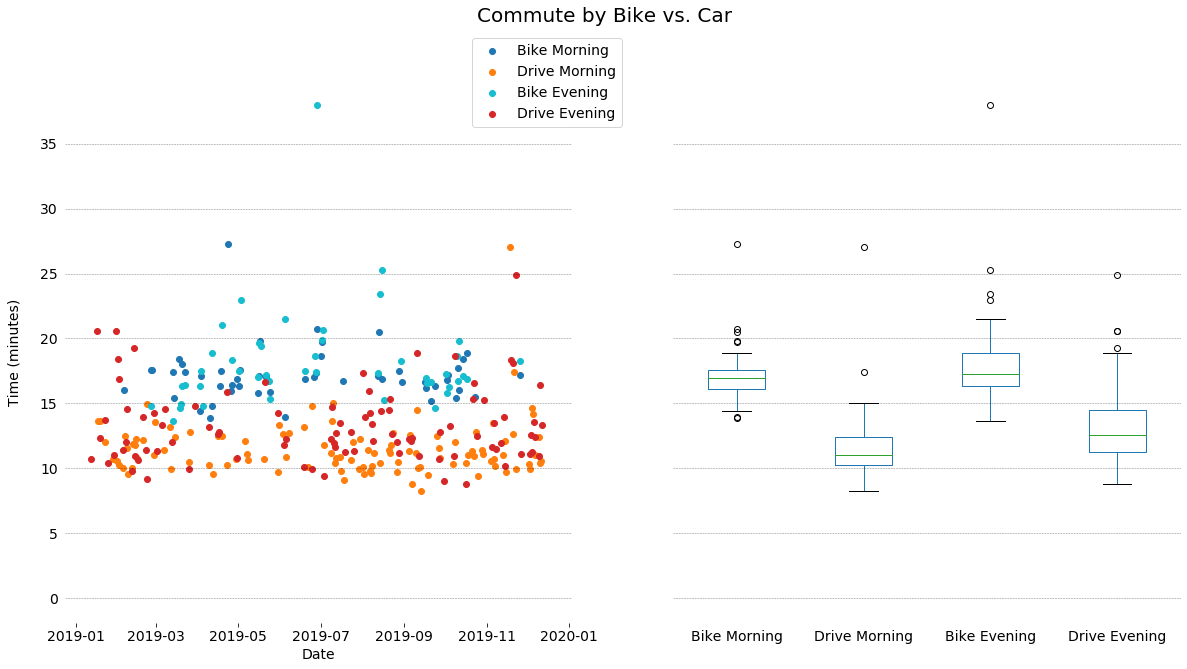

In [48]:
# Creating a nice plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
to_plot = visualize.prepare_for_plotting(morning_commutes)
to_plot_car = visualize.prepare_for_plotting(drive_morning.dropna())
to_plot_evening_bike = visualize.prepare_for_plotting(evening_commutes)
to_plot_evening_car = visualize.prepare_for_plotting(drive_evening.dropna())
axes[0].scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C0')
axes[0].scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C1')
axes[0].scatter(to_plot_evening_bike['start_date_local'].dt.to_pydatetime(), to_plot_evening_bike['elapsed_time'], color='C9')
axes[0].scatter(to_plot_evening_car['start_date_local'].dt.to_pydatetime(), to_plot_evening_car['elapsed_time'], color='C3')
axes[0].legend(['Bike Morning', 'Drive Morning', "Bike Evening", "Drive Evening"], bbox_to_anchor=[.79,.9])
hist_plot = pd.concat(
    (
        to_plot["elapsed_time"],
        to_plot_car["elapsed_time"],
        to_plot_evening_bike["elapsed_time"],
        to_plot_evening_car["elapsed_time"],
    ),
    axis=1
)
#  to_plot_bike = to_plot
#  to_plot['bike_moving_time'] = to_plot_bike['moving_time']
#  to_plot['Biking Morning'] = to_plot_bike['elapsed_time']
#  to_plot['Driving Morning'] = to_plot_car['elapsed_time']
#  to_plot['Biking Evening'] = to_plot_evening_bike['elapsed_time']
#  to_plot['Driving Evening'] = to_plot_evening_car['elapsed_time']
#  to_plot[['Biking Morning', 'Driving Morning', 'Biking Evening', 'Driving Evening']].plot.box(ax=axes[1], showfliers=False)
hist_plot.columns = ["Bike Morning", "Drive Morning", "Bike Evening", "Drive Evening"]
hist_plot.plot.box(ax=axes[1])
fig.text(0.09, 0.5, 'Time (minutes)', ha='center', va='center', rotation='vertical')
axes[0].set_xlabel('Date')
fig.suptitle('Commute by Bike vs. Car', fontsize = 20)
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
#plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)
#plt.xticks(fontsize=14)
for y in range(0, 36, 5):
    for ax in axes:
        ax.tick_params(axis="both", which="both", bottom=False, top=False,
        labelbottom=True, left=False, right=False, labelleft=True)
        ax.axhline(y=y, linestyle='--', lw=0.5, color='black', alpha=0.5)
        #ax.plot_date([to_plot_car['start_date_local'].min(), to_plot_bike['start_date_local'].max()], [y, y],  "--", lw=0.5, color="black", alpha=0.9)
axes[0].tick_params(axis='both', which="both", bottom=True)
axes[1].tick_params(axis='both', labelleft=False)
# plt.savefig("figures/to_post.png", bbox_inches="tight")
plt.show()



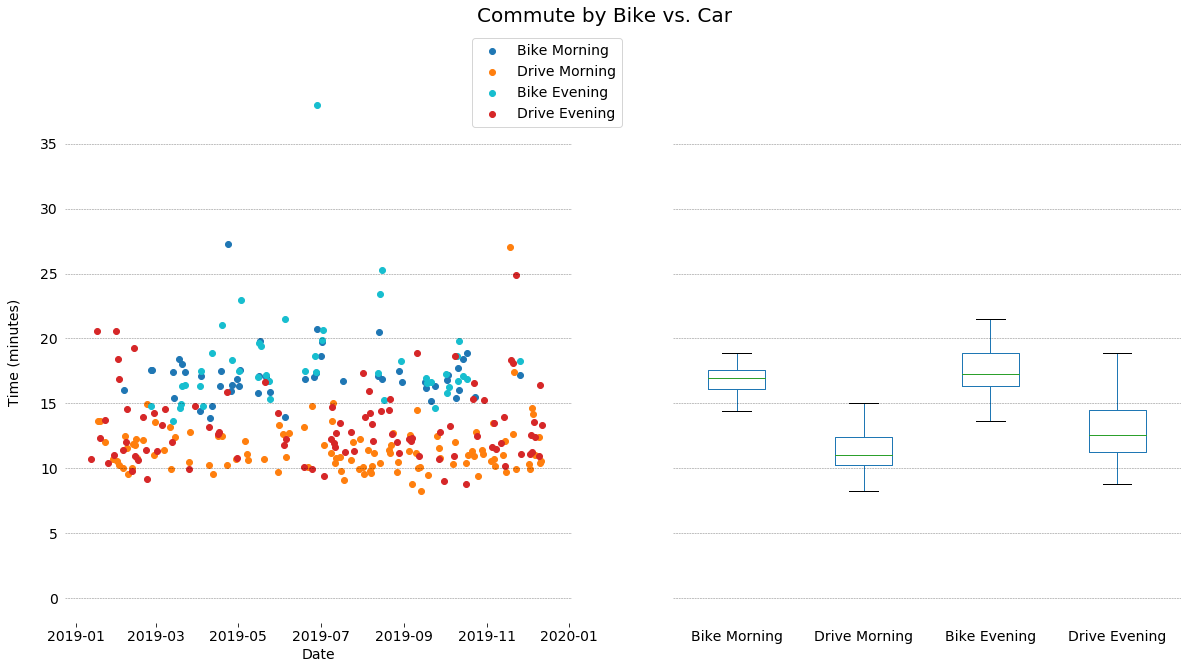

In [50]:
# Creating a nice plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
to_plot = visualize.prepare_for_plotting(morning_commutes)
to_plot_car = visualize.prepare_for_plotting(drive_morning.dropna())
to_plot_evening_bike = visualize.prepare_for_plotting(evening_commutes)
to_plot_evening_car = visualize.prepare_for_plotting(drive_evening.dropna())
axes[0].scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C0')
axes[0].scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C1')
axes[0].scatter(to_plot_evening_bike['start_date_local'].dt.to_pydatetime(), to_plot_evening_bike['elapsed_time'], color='C9')
axes[0].scatter(to_plot_evening_car['start_date_local'].dt.to_pydatetime(), to_plot_evening_car['elapsed_time'], color='C3')
axes[0].legend(['Bike Morning', 'Drive Morning', "Bike Evening", "Drive Evening"], bbox_to_anchor=[.79,.9])
hist_plot = pd.concat(
    (
        to_plot["elapsed_time"],
        to_plot_car["elapsed_time"],
        to_plot_evening_bike["elapsed_time"],
        to_plot_evening_car["elapsed_time"],
    ),
    axis=1
)
#  to_plot_bike = to_plot
#  to_plot['bike_moving_time'] = to_plot_bike['moving_time']
#  to_plot['Biking Morning'] = to_plot_bike['elapsed_time']
#  to_plot['Driving Morning'] = to_plot_car['elapsed_time']
#  to_plot['Biking Evening'] = to_plot_evening_bike['elapsed_time']
#  to_plot['Driving Evening'] = to_plot_evening_car['elapsed_time']
#  to_plot[['Biking Morning', 'Driving Morning', 'Biking Evening', 'Driving Evening']].plot.box(ax=axes[1], showfliers=False)
hist_plot.columns = ["Bike Morning", "Drive Morning", "Bike Evening", "Drive Evening"]
hist_plot.plot.box(ax=axes[1], showfliers=False)
fig.text(0.09, 0.5, 'Time (minutes)', ha='center', va='center', rotation='vertical')
axes[0].set_xlabel('Date')
fig.suptitle('Commute by Bike vs. Car', fontsize = 20)
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
#plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)
#plt.xticks(fontsize=14)
for y in range(0, 36, 5):
    for ax in axes:
        ax.tick_params(axis="both", which="both", bottom=False, top=False,
        labelbottom=True, left=False, right=False, labelleft=True)
        ax.axhline(y=y, linestyle='--', lw=0.5, color='black', alpha=0.5)
        #ax.plot_date([to_plot_car['start_date_local'].min(), to_plot_bike['start_date_local'].max()], [y, y],  "--", lw=0.5, color="black", alpha=0.9)
axes[0].tick_params(axis='both', which="both", bottom=True)
axes[1].tick_params(axis='both', labelleft=False)
# plt.savefig("figures/to_post.png", bbox_inches="tight")
plt.show()



In [150]:
print(len(morning_commutes))
print(len(evening_commutes))
print(len(drive_morning))
print(len(drive_evening))

52
45
111
93


In [151]:
year_frame = pd.DataFrame()
for df_to_add, t in zip((drive_morning, drive_evening, morning_commutes, evening_commutes), (1, 1, 2, 2)):
    to_append = pd.DataFrame()
    to_append["start_date_local"] = df_to_add["start_date_local"].dt.date
    to_append["type"] = t
    year_frame = pd.concat([year_frame, to_append])
year_frame["start_date_local"] = pd.to_datetime(year_frame["start_date_local"])
year_frame = year_frame.set_index("start_date_local")

In [152]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

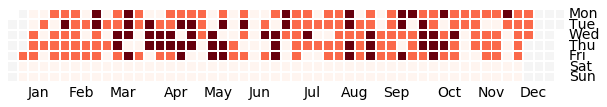

In [155]:
import calmap
year_frame = year_frame.loc[~year_frame.index.duplicated(keep="first")]
calmap.yearplot(test.T.squeeze(), year=2019)


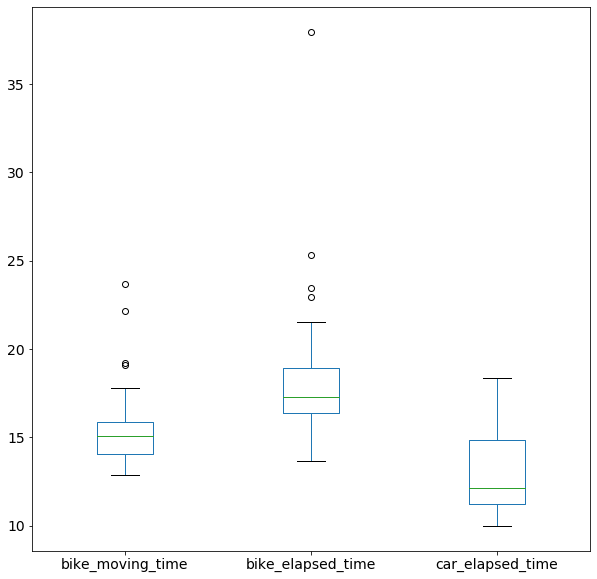

In [156]:
to_plot_bike = visualize.prepare_for_plotting(evening_commutes)
to_plot_car = visualize.prepare_for_plotting(drive_evening)
to_plot = pd.DataFrame()
to_plot['bike_moving_time'] = to_plot_bike['moving_time']
to_plot['bike_elapsed_time'] = to_plot_bike['elapsed_time']
to_plot['car_elapsed_time'] = to_plot_car['elapsed_time']

to_plot[['bike_moving_time', 'bike_elapsed_time', 'car_elapsed_time']].plot.box()
plt.show()


In [18]:
map_lat_lng = (33.765734, -84.371476)
pl = polyline.decode(strava_data['map'][0]["summary_polyline"])
m = folium.Map(map_lat_lng, zoom_start=14)
bike_path = folium.PolyLine(pl).add_to(m)
m


In [19]:
gt_lat_lng = (33.777351, -84.396541)
map_lat_lng = (33.775734, -84.381476)
visualize.plot_polylines(evening_commutes, map_lat_lng)

In [20]:
gt_lat_lng = (33.777351, -84.396541)
map_lat_lng = (33.775734, -84.381476)
visualize.plot_polylines(morning_commutes, map_lat_lng)

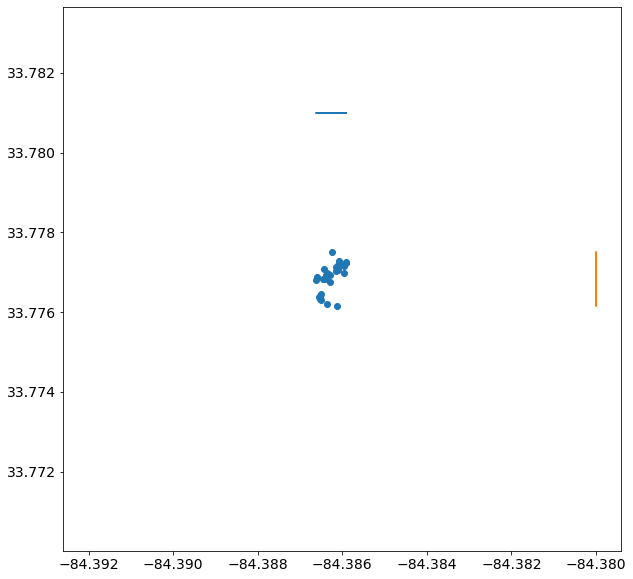

In [59]:
m = folium.Map(map_lat_lng, zoom_start=14)
end_latlng = []
for (index, row) in evening_commutes.iterrows():
    if (row['map']['summary_polyline']):
        pl = polyline.decode(row['map']['summary_polyline'])
        end_latlng.append(pl[1])
temp = list(zip(*end_latlng))
end_lat = temp[0]
end_lng = temp[1]
plt.scatter(end_lng, end_lat)
hline = [33.781 for i in range(0, len(end_lng))]
vline = [-84.38 for i in range(0, len(end_lat))]
plt.plot(end_lng, hline)
plt.plot(vline, end_lat)

In [60]:
evening_commutes_gtri = strava_data[evening_mask & weekday_mask & normal_time_mask & distance_mask & gtri_start_mask]
evening_commutes_gt = strava_data[evening_mask & weekday_mask & normal_time_mask & distance_mask & gt_start_mask]

In [61]:
temp= 'Index: ' + (pd.Series(to_plot.index)).apply(str)

In [62]:
# Index printing issues: https://stackoverflow.com/questions/32801806/pandas-concat-ignore-index-doesnt-work
to_plot = visualize.prepare_for_plotting(evening_commutes)
#plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'])
#to_plot['index_str'] = 'Index: ' + pd.Series(to_plot.index).apply(str)
data = [
    go.Scatter(
        x = to_plot.start_date_local.dt.to_pydatetime(),
        y = to_plot.elapsed_time,
        hoverinfo = 'text',
        marker = dict(
            color = 'green'
        ),
        showlegend = False,
        mode = 'markers',
        text = to_plot.index
    )
]

layout = go.Layout(
    title = "Bike Evening Commutes",
    titlefont = dict(
        size = 10
    ),
    xaxis = dict(
        zeroline = True
    ),
    yaxis = dict(
    )
)



fig = {
    'data': [
        {
            'x': to_plot.start_date_local.dt.to_pydatetime(),
            'y': to_plot.elapsed_time,
            'mode': 'markers',
            'name': 'Biking',
            'text': to_plot.index
        }
    ]
}

fig2 = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
iplot(fig2, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

NameError: name 'go' is not defined

In [63]:
to_plot['index'].head()

KeyError: 'index'

In [13]:
'Prepend' + to_plot['index']

KeyError: 'index'

In [14]:
data = [
    go.Scatter(
        'x': to_plot.start_date_local.dt.to_pydatetime(),
        'y': to_plot.elapsed_time,
        hoverinfo = 'y',
        marker = dict(
            color = 'green'
        ),
        showlegend = False
    )
]

layout = go.Layout(
    title = "Set hover text formatting<br><a href= https://github.com/d3/d3-time-format/blob/master/README.md#locale_format>https://github.com/d3/d3-time-format/blob/master/README.md#locale_format</a>",
    titlefont = dict(
        size = 10
    ),
    xaxis = dict(
        zeroline = False
    ),
    yaxis = dict(
        hoverformat = '.2f'
    )
)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename = "format-hover-text")

SyntaxError: invalid syntax (<ipython-input-14-6d49b8120bcc>, line 3)

In [16]:
# https://markhneedham.com/blog/2017/04/29/leaflet-strava-polylines-osm/
# https://dzone.com/articles/strava-calculating-the-similarity-of-two-runs
# http://bl.ocks.org/matt-leach/5336dc8249cf4401fc0f6b31743202e5
# http://andykee.com/visualizing-strava-tracks-with-python.html
# https://gis.stackexchange.com/questions/42224/creating-polyline-based-heatmap-from-gps-tracks
# https://yizeng.me/2017/01/11/get-a-strava-api-access-token-with-write-permission/